In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler

In [3]:
df = pd.read_csv('/content/drive/MyDrive/AI_Heart/Weather_Bhopal.csv')
df.head()

,DATE,MAX_TEMP,MIN_TEMP,RAINFALL_24_HRS
0,1/1/2020,18.5,9.7,0.0
1,1/2/2020,20.3,12.0,0.0
2,1/3/2020,20.7,14.0,0.0
3,1/4/2020,20.5,11.0,0.0
4,1/5/2020,17.0,7.2,0.0


In [4]:
df['DATE'] = pd.to_datetime(df['DATE'], infer_datetime_format=True) 

array([<Axes: xlabel='DATE'>, <Axes: xlabel='DATE'>], dtype=object)

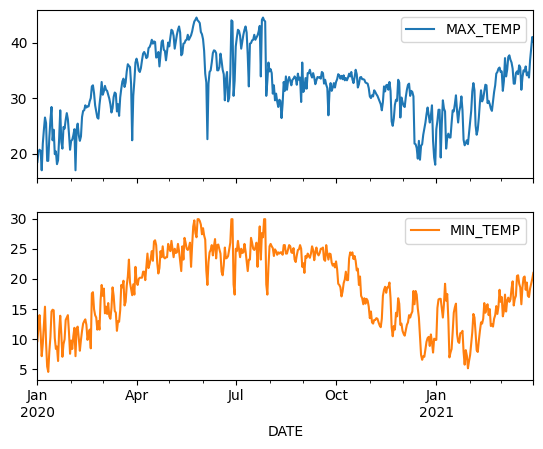

In [5]:
# to plot time series data
df.set_index('DATE')[['MAX_TEMP', 'MIN_TEMP']].plot(subplots=True)

In [6]:
df.describe()

,MAX_TEMP,MIN_TEMP,RAINFALL_24_HRS
count,456.000000,456.000000,456.00000
mean,32.059430,18.298465,2.05693
std,6.042076,6.088542,9.35162
min,17.000000,4.600000,0.00000
25%,28.400000,13.400000,0.00000
50%,32.500000,18.600000,0.00000
75%,35.500000,24.000000,0.00000
max,44.500000,29.900000,126.20000


In [7]:
df

,DATE,MAX_TEMP,MIN_TEMP,RAINFALL_24_HRS
0,2020-01-01,18.5,9.7,0.0
1,2020-01-02,20.3,12.0,0.0
2,2020-01-03,20.7,14.0,0.0
3,2020-01-04,20.5,11.0,0.0
4,2020-01-05,17.0,7.2,0.0
...,...,...,...,...
451,2021-03-27,33.7,17.0,0.0
452,2021-03-28,36.8,18.4,0.0
453,2021-03-29,38.9,19.2,0.0
454,2021-03-30,41.0,20.0,0.0


In [8]:
#input_df = df[['RAINFALL_24_HRS', 'MAX_TEMP', 'MIN_TEMP']]
input_df = df[['MAX_TEMP', 'MIN_TEMP', 'RAINFALL_24_HRS']]
input_df.head()

,MAX_TEMP,MIN_TEMP,RAINFALL_24_HRS
0,18.5,9.7,0.0
1,20.3,12.0,0.0
2,20.7,14.0,0.0
3,20.5,11.0,0.0
4,17.0,7.2,0.0


In [9]:
sca=MinMaxScaler()
data_sca = sca.fit_transform(input_df)

In [10]:
x = data_sca
y = data_sca[:,-1]

In [11]:
xtrain,xtest,ytrain,ytest = train_test_split(x,y,shuffle=False)

In [12]:
print(xtrain.shape)
print(ytrain.shape)

(342, 3)
(342,)


In [13]:
TimeseriesGenerator(xtrain,ytrain,length=2, sampling_rate=1, batch_size=1)[0]

(array([[[0.05454545, 0.20158103, 0.        ],
         [0.12      , 0.29249012, 0.        ]]]),
 array([0.]))

In [14]:
xtrain

array([[0.05454545, 0.20158103, 0.        ],
       [0.12      , 0.29249012, 0.        ],
       [0.13454545, 0.3715415 , 0.        ],
       ...,
       [0.52727273, 0.3083004 , 0.        ],
       [0.56      , 0.32411067, 0.        ],
       [0.56727273, 0.3715415 , 0.        ]])

In [15]:
win_len=50 
num_feature = 3
train_generator = TimeseriesGenerator(xtrain, ytrain, length=win_len, sampling_rate=1, batch_size=32)
test_generator = TimeseriesGenerator(xtest, ytest, length=win_len, sampling_rate=1, batch_size=32)

In [16]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import tensorflow as tf

In [17]:
model = Sequential()
model.add(LSTM(32, input_shape=(win_len, num_feature),activation='tanh', return_sequences=True)) # return sequence by default false, intermediate values should be stored or not, here we will keep it as true
model.add(LSTM(32,activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
# dropout is used to minimise overfitting, select 20 neurons which are not contributing, so goal is to give equal oppurtunity to all neurons
model.add(LSTM(32,activation='tanh', return_sequences=True)) 
model.add(Dropout(0.2))
model.add(LSTM(32,activation='tanh', return_sequences=False)) # last layer, keep return_sequences=False because we only want output
model.add(Dense(1))

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 32)            4608      
                                                                 
 lstm_1 (LSTM)               (None, 50, 32)            8320      
                                                                 
 dropout (Dropout)           (None, 50, 32)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50, 32)            8320      
                                                                 
 dropout_1 (Dropout)         (None, 50, 32)            0         
                                                                 
 lstm_3 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 3

In [19]:
from keras.callbacks import EarlyStopping

In [20]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=3) 

In [21]:
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer='adam', metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [22]:
from keras import callbacks
hist = model.fit_generator(train_generator, epochs=5, validation_data=test_generator, callbacks=[early_stopping], shuffle=False)

Epoch 1/5


<ipython-input-22-1423d245b9bd>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(train_generator, epochs=5, validation_data=test_generator, callbacks=[early_stopping], shuffle=False)


10/10 [==============================] - 8s 210ms/step - loss: 0.0088 - mean_absolute_error: 0.0468 - val_loss: 6.2192e-04 - val_mean_absolute_error: 0.0222
Epoch 2/5
10/10 [==============================] - 1s 72ms/step - loss: 0.0089 - mean_absolute_error: 0.0333 - val_loss: 6.7548e-04 - val_mean_absolute_error: 0.0237
Epoch 3/5
10/10 [==============================] - 1s 91ms/step - loss: 0.0083 - mean_absolute_error: 0.0436 - val_loss: 4.6230e-04 - val_mean_absolute_error: 0.0163
Epoch 4/5
10/10 [==============================] - 1s 101ms/step - loss: 0.0083 - mean_absolute_error: 0.0354 - val_loss: 4.0844e-04 - val_mean_absolute_error: 0.0128
Epoch 5/5
10/10 [==============================] - 1s 96ms/step - loss: 0.0081 - mean_absolute_error: 0.0396 - val_loss: 3.9245e-04 - val_mean_absolute_error: 0.0105


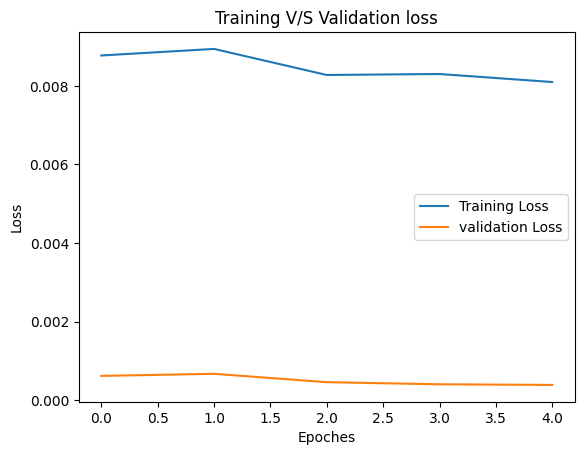

In [23]:
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='validation Loss')
plt.xlabel('Epoches')
plt.ylabel('Loss')
plt.title("Training V/S Validation loss")
plt.legend()

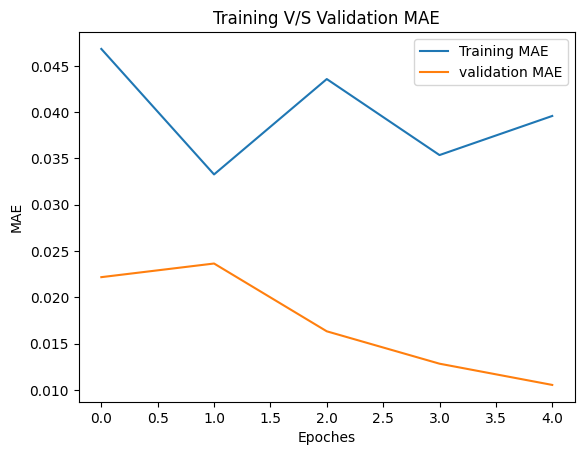

In [24]:
plt.plot(hist.history['mean_absolute_error'], label='Training MAE')
plt.plot(hist.history['val_mean_absolute_error'], label='validation MAE')
plt.xlabel('Epoches')
plt.ylabel('MAE')
plt.title("Training V/S Validation MAE")
plt.legend()

In [25]:
ypred = model.predict(test_generator)

2/2 [==============================] - 1s 19ms/step


In [26]:
ypred.shape

(64, 1)

In [27]:
xtest.shape

(114, 3)

In [28]:
df_pred = pd.concat([pd.DataFrame(ypred), pd.DataFrame(xtest[2:,1:][win_len:])], axis=1)

In [29]:
df_pred

,0,0,1
0,0.009708,0.106719,0.0
1,0.008846,0.023715,0.0
2,0.008035,0.071146,0.0
3,0.007284,0.110672,0.0
4,0.006567,0.189723,0.0
...,...,...,...
59,0.016097,0.577075,0.0
60,0.016527,0.608696,0.0
61,0.016856,0.648221,0.0
62,0.017068,NaN,NaN


In [30]:
df_final = sca.inverse_transform(df_pred) # inverse of normalisation function
df_final

array([[1.72669736e+01, 7.30000000e+00, 0.00000000e+00],
       [1.72432621e+01, 5.20000000e+00, 0.00000000e+00],
       [1.72209641e+01, 6.40000000e+00, 0.00000000e+00],
       [1.72002992e+01, 7.40000000e+00, 0.00000000e+00],
       [1.71805886e+01, 9.40000000e+00, 0.00000000e+00],
       [1.71608503e+01, 1.12000000e+01, 0.00000000e+00],
       [1.71404168e+01, 1.42000000e+01, 0.00000000e+00],
       [1.71191792e+01, 1.36000000e+01, 0.00000000e+00],
       [1.70972792e+01, 1.11000000e+01, 0.00000000e+00],
       [1.70759538e+01, 8.20000000e+00, 0.00000000e+00],
       [1.70566931e+01, 7.90000000e+00, 0.00000000e+00],
       [1.70412759e+01, 9.80000000e+00, 0.00000000e+00],
       [1.70303196e+01, 1.14000000e+01, 0.00000000e+00],
       [1.70232332e+01, 1.28000000e+01, 0.00000000e+00],
       [1.70191821e+01, 1.26000000e+01, 0.00000000e+00],
       [1.70173045e+01, 1.34000000e+01, 0.00000000e+00],
       [1.70168706e+01, 1.60000000e+01, 0.00000000e+00],
       [1.70178327e+01, 1.44000

In [31]:
df_main = input_df[ypred.shape[0]*-1:]
df_main.count()

MAX_TEMP           64
MIN_TEMP           64
RAINFALL_24_HRS    64
dtype: int64

In [32]:
df_main['Weather_Pred'] = df_final[:,-1]
df_main

<ipython-input-32-3e9813e1162d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_main['Weather_Pred'] = df_final[:,-1]


,MAX_TEMP,MIN_TEMP,RAINFALL_24_HRS,Weather_Pred
392,21.5,5.8,0.0,0.0
393,21.9,8.2,0.0,0.0
394,22.4,7.3,0.0,0.0
395,21.7,5.2,0.0,0.0
396,23.7,6.4,0.0,0.0
...,...,...,...,...
451,33.7,17.0,0.0,0.0
452,36.8,18.4,0.0,0.0
453,38.9,19.2,0.0,0.0
454,41.0,20.0,0.0,NaN


In [33]:
print(df_main.columns)

Index(['MAX_TEMP', 'MIN_TEMP', 'RAINFALL_24_HRS', 'Weather_Pred'], dtype='object')


<Axes: >

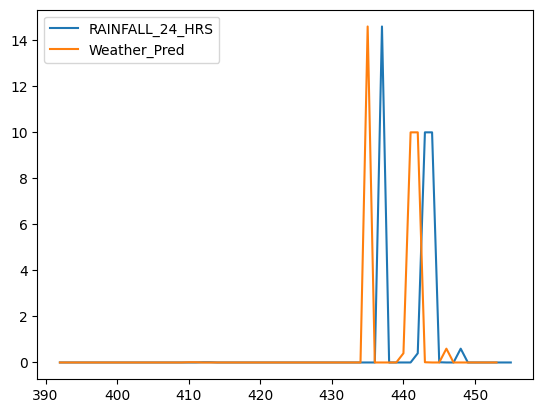

In [34]:
df_main[['RAINFALL_24_HRS', 'Weather_Pred']].plot()